# Quantum Fourier transform

In classical or mathematical terms, a Fourier transform of a time-varying signal would give its frequency distribution, or the Fourier transform of a distribution in space will tell us if there is spatially periodicity. If we keep the phase information as well as the amplitude, then we do not lose any information, we are just writing it in a different way.

The quantum Fourier transform takes our qubit state from the computational basis into the "Fourier basis":

$QFT| x \rangle = | \tilde{x} \rangle$

For example, we could count in binary from 0 to 15 using 4 qubits like this:

![zbasiscounting](images/zbasis-counting.gif)

corresponding to the binary numbers 0000, 0001, 0010, 0011, 0100... etc. 

The QFT of this looks like

![fbasiscounting](images/fourierbasis-counting.gif)

Note how qubit 0 makes a complete rotation as we go from 0 to 15, so it contains the "full" value of the number but each step is relatively small. The other qubits rotate progressively faster, by a factor of 2 each time, giving us more precision in the overall value.

Mathematically, to encode the number $n$ on 4 qubits, we rotate the $i^{th}$ qubit from $| + \rangle$ by $$2\pi n \frac{2^i}{2^4}$$

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_distribution, plot_histogram, array_to_latex
from qiskit.result import Result
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import Aer
from math import sqrt, pi

### use vector_to_latex code from qiskit 0.44
from vector_to_latex import *

In [14]:
qin = 1# input number

#encode this number in the computational basis
q3 = qin//8
q2 = (qin-8*q3)//4
q1 = (qin-8*q3-4*q2)//2
q0 = qin-8*q3-4*q2-2*q1

qcomp=[q0,q1,q2,q3]

print(q3,q2,q1,q0)

qc = QuantumCircuit(4)

#encode this number into qubit states using X gates:
for q in range(4):
    if qcomp[q]==1:
        qc.x(q)

display(qc.draw())

0 0 0 1


┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
          
q_2: ─────
          
q_3: ─────

The most significant qubit is $q_3$, so if it's $|0\rangle$ we apply $H$ to put this into $|+\rangle$ and if it's $|1\rangle$(meaning that the number is at least 8) the H will put it into $|-\rangle$. Like a rotation of $\pi$ compared to $|+\rangle$ which would already correspond to the number 8.

And then we need to rotate $q_3$ by a quarter turn if $q_2$ is $|1\rangle$, Like we apply a controlled rotation phase around Z with $\theta = \pi/2$ if there's contribution coming from the qubit with value 4.

similarly, we rotate $q_3$ by $1/8$ of a turn if $q_1$ is $| 1 \rangle$, i.e. we apply a controlled rotation phase around $Z$ with $\theta = \pi/4$ if there's a contribution of value 2.

and finally we rotate $q_3$ by a $1/16$ of a turn if $q_0$ is $| 1 \rangle$, i.e. we apply a controlled rotation phase around $Z$ with $\theta = \pi/8$ if there's a contribution of value 1.

In [15]:
qc.h(3)
display(qc.draw())

qc.cp(pi/2,2,3)
display(qc.draw())

qc.cp(pi/4,1,3)
display(qc.draw())

qc.cp(pi/8,0,3)
display(qc.draw())

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ H ├
     └───┘

┌───┐         
q_0: ┤ X ├─────────
     └───┘         
q_1: ──────────────
                   
q_2: ──────■───────
     ┌───┐ │P(π/2) 
q_3: ┤ H ├─■───────
     └───┘

┌───┐                  
q_0: ┤ X ├──────────────────
     └───┘                  
q_1: ───────────────■───────
                    │       
q_2: ──────■────────┼───────
     ┌───┐ │P(π/2)  │P(π/4) 
q_3: ┤ H ├─■────────■───────
     └───┘

┌───┐                           
q_0: ┤ X ├───────────────────■───────
     └───┘                   │       
q_1: ───────────────■────────┼───────
                    │        │       
q_2: ──────■────────┼────────┼───────
     ┌───┐ │P(π/2)  │P(π/4)  │P(π/8) 
q_3: ┤ H ├─■────────■────────■───────
     └───┘

and we need to do a similar thing for the lesser qubits

In [16]:
qc.h(2)
qc.cp(pi/2,1,2)
qc.cp(pi/4,0,2)

qc.h(1)
qc.cp(pi/2,0,1)

qc.h(0)

qc.draw()

┌───┐                                                                ┌───┐
q_0: ┤ X ├────────────────────────■─────────────────■─────────────■───────┤ H ├
     └───┘                        │                 │       ┌───┐ │P(π/2) └───┘
q_1: ───────────────■─────────────┼────────■────────┼───────┤ H ├─■────────────
                    │       ┌───┐ │        │P(π/2)  │P(π/4) └───┘              
q_2: ──────■────────┼───────┤ H ├─┼────────■────────■──────────────────────────
     ┌───┐ │P(π/2)  │P(π/4) └───┘ │P(π/8)                                      
q_3: ┤ H ├─■────────■─────────────■────────────────────────────────────────────
     └───┘

repeat the whole circuit here for convience in re-running it, and in order to make it match the example given above we need to swap the qubits around the end.


In [17]:
qin = 1 # input number

# encode this number in the computational basis
q3 = qin//8
q2 = (qin-8*q3)//4
q1 = (qin-8*q3-4*q2)//2
q0 = qin-8*q3-4*q2-2*q1

qcomp=[q0,q1,q2,q3]

# print(q3, q2, q1, q0)

qc = QuantumCircuit(4)

# encode this number into qubit states using X gates:
for q in range(4):
    if qcomp[q]==1:
        qc.x(q)

qc.h(3)        
qc.cp(pi/2,2,3)
qc.cp(pi/4,1,3)
qc.cp(pi/8,0,3)

qc.h(2)
qc.cp(pi/2,1,2)
qc.cp(pi/4,0,2)

qc.h(1)
qc.cp(pi/2,0,1)

qc.h(0)

qc.swap(0,3)
qc.swap(1,2)

qc.draw()

┌───┐                                                                ┌───┐»
q_0: ┤ X ├────────────────────────■─────────────────■─────────────■───────┤ H ├»
     └───┘                        │                 │       ┌───┐ │P(π/2) └───┘»
q_1: ───────────────■─────────────┼────────■────────┼───────┤ H ├─■─────────X──»
                    │       ┌───┐ │        │P(π/2)  │P(π/4) └───┘           │  »
q_2: ──────■────────┼───────┤ H ├─┼────────■────────■───────────────────────X──»
     ┌───┐ │P(π/2)  │P(π/4) └───┘ │P(π/8)                                      »
q_3: ┤ H ├─■────────■─────────────■────────────────────────────────────────────»
     └───┘                                                                     »
«        
«q_0: ─X─
«      │ 
«q_1: ─┼─
«      │ 
«q_2: ─┼─
«      │ 
«q_3: ─X─
«

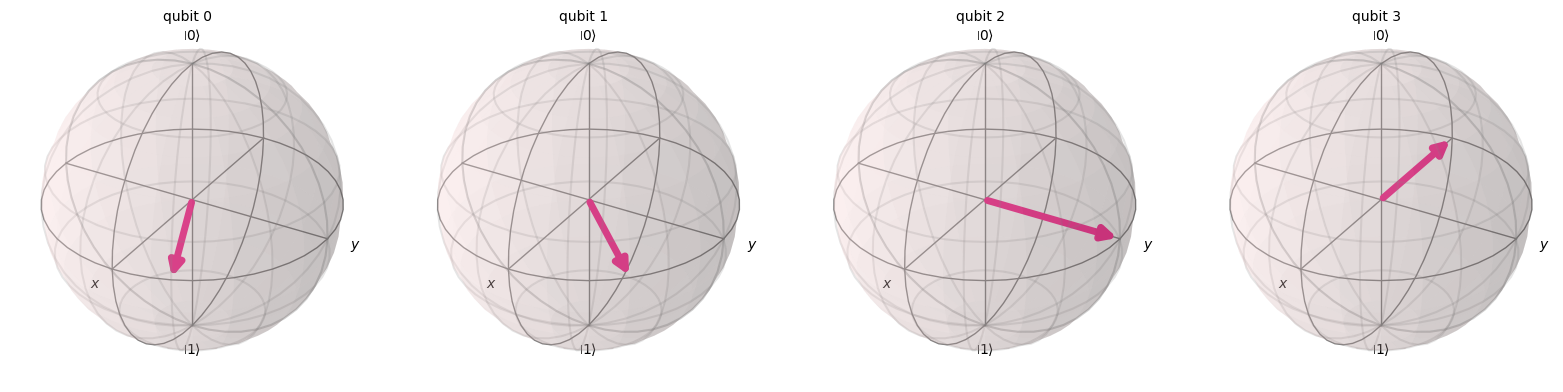

In [18]:
svsim = Aer.get_backend('statevector_simulator')
state = svsim.run(qc).result().get_statevector()
plot_bloch_multivector(state)

Now counting the $X$ gates use to encode the input number or need add the $SWAP$ gates at the ebd, the $QFT$ on 4 bits requires 10 operations. If we only had one qubit, we would only need one operation (an $H$) but for two qubits, the second qubit needs two operations plus the one operation from the first qubit, and so on, so the scaling is slightly less than the number of bits squared.

The QFT is an essential feature of Shor's factoring algorithm and quantum phase estimation.

Of course we cannot measure the QFT state directly, since the states are not in the computational basis. Measuring them would collapse each one randomly to $|0\rangle$ of $|1\rangle$ and destroy the phase information.

# Inverse QFT

The $QFT^{\dagger}$ takes the QFT state and converts it back to the computational basis.

In [19]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [20]:
#for example

qubits=4
qcqft = QuantumCircuit(qubits)
qcqft.append(qft_dagger(qubits), range(qubits))
qcqft.decompose().draw()

┌───┐                                                            »
q_0: ────X─┤ H ├─■─────────■──────────────■─────────────────────────────────»
         │ └───┘ │P(-π/2)  │        ┌───┐ │                                 »
q_1: ─X──┼───────■─────────┼────────┤ H ├─┼─────────■─────────■─────────────»
      │  │                 │P(-π/4) └───┘ │         │P(-π/2)  │        ┌───┐»
q_2: ─X──┼─────────────────■──────────────┼─────────■─────────┼────────┤ H ├»
         │                                │P(-π/8)            │P(-π/4) └───┘»
q_3: ────X────────────────────────────────■───────────────────■─────────────»
                                                                            »
«                    
«q_0: ───────────────
«                    
«q_1: ───────────────
«                    
«q_2: ─■─────────────
«      │P(-π/2) ┌───┐
«q_3: ─■────────┤ H ├
«               └───┘

Following the swaps which re-order the qubits according to significance, we can see that $q_0$, which should be in either $|+\rangle$ or $|-\rangle$, is put back to either $|0\rangle$ or $|1\rangle$ respectively by an $H$ gate. This is then used as a control to remove $\pi/2$ of phase from $q_1$ since if $q_0$ was rotated by $\pi$ from $|+\rangle$ to $|-\rangle$, then $q_1$ will have been rotated by $\pi/2$ from either $|+\rangle$ or $|-\rangle$. An $H$ can then be applied to $q_1$. Meanwhile $q_0$ is used as a control to remove a phase of $\pi/4$ from $q_2$ and $\pi/8$ from $q_3$. Cascading down, $q_1$ is used as a control to remove a phase of $\pi/2$ from $q_2$ and $\pi/4$ from $q_3$ and so on.

When we perform the QFT on $n$ qubits we know that the phases should correspond to exact $2^m$ fractions of $2\pi$ such that $q_0$ completes $2\pi$ of rotation from 0 to $2^{n}-1$, $q_0$ completes $4\pi$ of rotation, etc. We will see in the case of Quantum Phase Estimation what happens if the phase is not a whole rotation divided by a power of 2.